<a href="https://colab.research.google.com/github/RP-SDAAI/Computer-Vision/blob/main/C3849C_CWF_Part3_LimZhaoHong_20065320_Copy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs and People Detection (Thermal images) with YOLOv5 - Transfer Learning

This activity is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on dogs and people thermal images. 

To speed up data preparation, we will use Roboflow's clean data management tools.  This technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

Ref: [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this activity

In this activity, we will walk through the steps required to train YOLOv5 on our thermal images. We use a [public Thermal dogs and people dataset](https://public.roboflow.com/object-detection/thermal-dogs-and-people), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download YOLOv5 object detection datasets and meta data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference






#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
from tqdm import tqdm

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5


# Then, we can take a look at our training environment provided to us for free from Google Colab.
import torch
from IPython.display import Image, clear_output  # to display images
#from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


# Download Correctly Formatted Dataset 

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

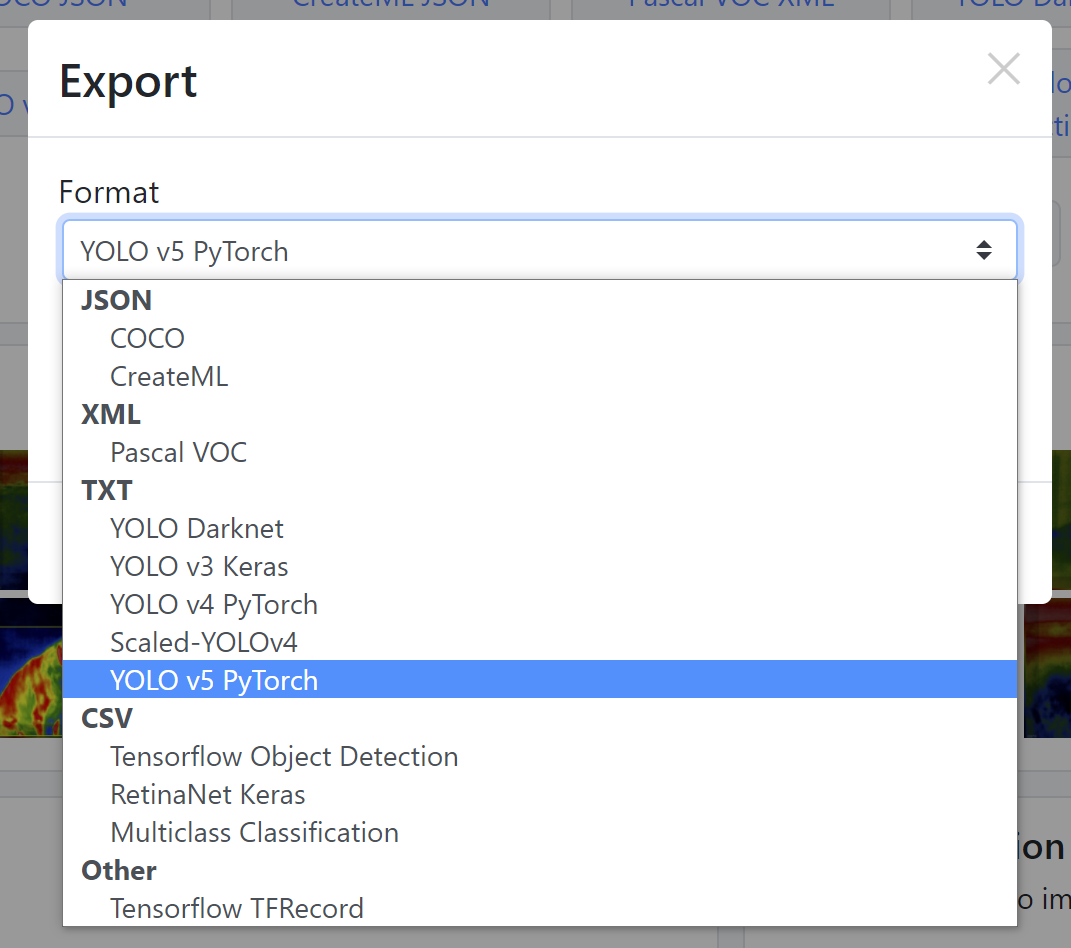



**Quick Note on Labeling Tools**

If you have unlabeled images, you will first need to label them. For free open source labeling tools, you can try [Roboflow Annotate](https://docs.roboflow.com/annotate) or the following guides on [getting started with LabelImg](https://blog.roboflow.com/getting-started-with-labelimg-for-labeling-object-detection-data/) or [getting started with CVAT](https://blog.roboflow.com/getting-started-with-cvat/) annotation tools. Try labeling ~50 images to get a feel of labeling. To improve your model's performance later, you will want to label more.



In [ ]:
# Export code snippet and paste here
%cd /content

#reference website https://universe.roboflow.com/sean-tan-oolsh/toycar-detection-and-tracking/dataset/3
!curl -L "https://universe.roboflow.com/ds/cEidBqRRUp?key=gD0oZxiWAX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   3850      0 --:--:-- --:--:-- --:--:--  3866
100 9588k  100 9588k    0     0  23.2M      0 --:--:-- --:--:-- --:--:-- 23.2M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/toycars_mp4-101_jpg.rf.3f2fdd993530918091951ec45cde26ec.jpg  
 extracting: test/images/toycars_mp4-20_jpg.rf.4e9bd966a5c93267ab05fd58aca32f63.jpg  
 extracting: test/images/toycars_mp4-33_jpg.rf.a2ea3b1f3248f378f8fa07c250f55f04.jpg  
 extracting: test/images/toycars_mp4-34_jpg.rf.b46a49b7ae615bd06e5f4ca458471ed5.jpg  
 extracting: test/images/toycars_mp4-35_jpg.rf.6441104bc57a2133d21c177262458d88.jpg  
 extracting: test/images/toycars_mp4-38_jpg.rf.66fa373a97d9dd0

The export creates a YOLOv5 .yaml file called `data.yaml` specifying the location of a YOLOv5 `images` folder, a YOLOv5 `labels` folder, and information on our custom classes.

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml ###For Project: Need to manually create the file with content inside. To edit the folder location of train..val ; nc (number of class) number of class, name of class. Copy and paste both image and text annotation into the respective folder

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['bus', 'car', 'truck']

roboflow:
  workspace: project
  project: toycar-detection-and-tracking
  version: 3
  license: CC BY 4.0
  url: https://universe.roboflow.com/project/toycar-detection-and-tracking/dataset/3

# Define Model Configuration and Architecture

Next we write a model configuration file for our custom object detector. For this activity, we chose the smallest, fastest base model of YOLOv5. You have the option to pick from other YOLOv5 models including:

* YOLOv5s
* YOLOv5m
* YOLOv5l
* YOLOv5x

You can also edit the structure of the network in this step, though rarely will you need to do this. Here is the YOLOv5 model configuration file, which we term `custom_yolov5s.yaml`:




```
nc: 3
depth_multiple: 0.33
width_multiple: 0.50

anchors:
  - [10,13, 16,30, 33,23] 
  - [30,61, 62,45, 59,119]
  - [116,90, 156,198, 373,326] 

backbone:
  [[-1, 1, Focus, [64, 3]],
   [-1, 1, Conv, [128, 3, 2]],
   [-1, 3, Bottleneck, [128]],
   [-1, 1, Conv, [256, 3, 2]],
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]], 
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 6, BottleneckCSP, [1024]],
  ]

head:
  [[-1, 3, BottleneckCSP, [1024, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],
   [-2, 1, nn.Upsample, [None, 2, "nearest"]],
   [[-1, 6], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1]],
   [-1, 3, BottleneckCSP, [512, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],
   [-2, 1, nn.Upsample, [None, 2, "nearest"]],
   [[-1, 4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 3, BottleneckCSP, [256, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],

   [[], 1, Detect, [nc, anchors]],
  ]
```



We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))


In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!

With our `data.yaml` and `custom_yolov5s.yaml` files ready to go we are ready to train!

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl

During training, you want to be watching the mAP@0.5 to see how your detector is performing - see this post on [breaking down mAP](https://blog.roboflow.com/what-is-mean-average-precision-object-detection/).

# Evaluate Custom YOLOv5 Detector Performance

Now that we have completed training, we can evaluate how well the training procedure performed by looking at the validation metrics. The training script will drop tensorboard logs in runs. We visualize those here:

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
#%load_ext tensorboard
#%tensorboard --logdir runs

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
#!pwd

In [ ]:
# first, display our ground truth data
#print("GROUND TRUTH TRAINING DATA:")
#Image(filename='runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [ ]:
# print out an augmented training example
#print("GROUND TRUTH AUGMENTED TRAINING DATA:")
#Image(filename='runs/train/yolov5s_results/train_batch1.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

Now we take our trained model and make inference on test images. After training has completed model weights will save in `weights/`. For inference we invoke those weights along with a `conf` specifying model confidence (higher confidence required makes less predictions), and a inference `source`. `source` can accept a directory of images, individual images, video files, and also a device's webcam port. For source, I have moved our test/*jpg to `test/images/`.

In [ ]:
# trained weights are saved by default in our weights folder
#%ls runs/

In [ ]:
#%ls runs/train/yolov5s_results/weights

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
#%cd /content/yolov5/
#!python detect.py --weights  runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

Finally, we visualize our inference on ALL test images.  This will look much better with longer training above

In [ ]:
#import glob
#from IPython.display import Image, display

#for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
#    display(Image(filename=imageName))
#    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DataFolder = "/content/drive/MyDrive/SDAAI/TA1-1-C3849C-A-Computer-Vision/CWF"
#ThermalFolder = DataFolder + "/LU04_Thermal"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
toycar_model = "/content/drive/MyDrive/SDAAI/TA1-1-C3849C-A-Computer-Vision/CWF/model"
if not os.path.exists(toycar_model):
  os.makedirs(toycar_model)

%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt $toycar_model

Copy output images for reference

In [ ]:
#toycar_output = DataFolder+ "/output"
#if not os.path.exists(toycar_output):
#  os.makedirs(toycar_output)

#%cp /content/yolov5/runs/detect/exp/*.* $toycar_output

In [ ]:
#%ls $ThermalFolder -lR

Run inferrence with trained weights using tourch API

In [ ]:
model = torch.hub.load('.', 'custom', path="/content/drive/MyDrive/SDAAI/TA1-1-C3849C-A-Computer-Vision/CWF/model/best.pt", source='local') 

requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# Import the neccesary libraries
import torch

# Load the Model
model = torch.hub.load('.', 'custom', path="/content/drive/MyDrive/SDAAI/TA1-1-C3849C-A-Computer-Vision/CWF/model/best.pt", source='local') 

requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
def annotate_image(image):
    
    # perform precidtion
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image_rgb) 

    counter = 0    
    for i in range(len(results.pandas().xyxy[0].name)):
      name = results.pandas().xyxy[0].name[i]
 #    if name == "vehicle"
      if name  in ['car','truck','bus']:
        counter += 1

        startX = int(results.pandas().xyxy[0].xmin[i])
        startY = int(results.pandas().xyxy[0].ymin[i])
        endX = int(results.pandas().xyxy[0].xmax[i])
        endY = int(results.pandas().xyxy[0].ymax[i])
        confidence = results.pandas().xyxy[0].confidence[i]
        label = "{}: {:.2f}%".format(name, confidence * 100)
        if confidence > 0.6:
          cv2.rectangle(image, (startX, startY), (endX, endY),
                  (255,0,0), 2)
          y = startY - 15 if startY - 15 > 15 else startY + 15
          cv2.putText(image, label, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
          cv2.putText(image, "Number detected: " +str(counter), (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
    
    return image    

Process the video file

In [ ]:


video_in_file = DataFolder + "/toycars.mp4"
video_out_file = DataFolder + "/out.mp4"

print("[INFO] accessing video stream...")
v_out = None

v_in = cv2.VideoCapture(video_in_file)
total_frame = int(v_in.get(cv2.CAP_PROP_FRAME_COUNT ))

for frame_no in tqdm(range(total_frame), desc="Processing Video..."):

  (grabbed, frame) = v_in.read()

  # if the frame was not grabbed then we've reached the end of
  # the video stream so exit the script
  if not grabbed:
      print("[INFO] no frame read from stream - exiting")
      break
          
  annotated_img = annotate_image(frame)
      
  # check if the video writer is None
  if v_out is None:
      # initialize our video writer
      fourcc = cv2.VideoWriter_fourcc(*"mp4v")
      v_out = cv2.VideoWriter(video_out_file, fourcc, 
                  int(v_in.get(cv2.CAP_PROP_FPS)),
                  (frame.shape[1], frame.shape[0]), True) 

  # write the output frame to disk
  v_out.write(annotated_img)
    
# release the file pointers
print("\n[INFO] cleaning up...")
v_out.release()
v_in.release()

[INFO] accessing video stream...


Processing Video...: 100%|██████████| 900/900 [01:09<00:00, 12.92it/s]


[INFO] cleaning up...


Play the out.mp4 file.

In [ ]:
video_mp4 = DataFolder + "/out3.mp4"
!ffmpeg -y -loglevel info -i $video_out_file -vf scale=640:480 $video_mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

In [ ]:
show_local_mp4_video(video_mp4, width=640, height=480)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# Download sample video
!curl -o sample.mp4 https://www.sample-videos.com/video123/mp4/720/big_buck_bunny_720p_1mb.mp4

cap = cv2.VideoCapture('sample.mp4')
while cap.isOpened():
    ret, image = cap.read()

    if not ret:
      break

    cv2_imshow(image) # Note cv2_imshow, not cv2.imshow

    cv2.waitKey(1) & 0xff

cv2.destroyAllWindows()
cap.release()

In [ ]:
import cv2
import sys

(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')￼

if __name__ == '__main__' :

    # Set up tracker.
    # Instead of MIL, you can also use

    tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'CSRT']
    tracker_type = tracker_types[2]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
        if tracker_type == "CSRT":
            tracker = cv2.TrackerCSRT_create()

    # Read video
    video = cv2.VideoCapture("videos/chaplin.mp4")

    # Exit if video not opened.
    if not video.isOpened():
        print "Could not open video"
        sys.exit()

    # Read first frame.
    ok, frame = video.read()
    if not ok:
        print 'Cannot read video file'
        sys.exit()
    
    # Define an initial bounding box
    bbox = (287, 23, 86, 320)

    # Uncomment the line below to select a different bounding box
    bbox = cv2.selectROI(frame, False)

    # Initialize tracker with first frame and bounding box
    ok = tracker.init(frame, bbox)

    while True:
        # Read a new frame
        ok, frame = video.read()
        if not ok:
            break
        
        # Start timer
        timer = cv2.getTickCount()

        # Update tracker
        ok, bbox = tracker.update(frame)

        # Calculate Frames per second (FPS)
        fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);

        # Draw bounding box
        if ok:
            # Tracking success
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
        else :
            # Tracking failure
            cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

        # Display tracker type on frame
        cv2.putText(frame, tracker_type + " Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
    
        # Display FPS on frame
        cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);


        # Display result
        cv2.imshow("Tracking", frame)

        # Exit if ESC pressed
        k = cv2.waitKey(1) & 0xff
        if k == 27 : break